## Geospatial Data Exploration Task for Remote Sensing

#### Import modules

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import geoplot
import geoplot.crs as gcrs
import xarray as xr
import geopandas as gpd
from shapely.geometry import Polygon
from geogif import dgif, gif
import netCDF4
import os 

os.chdir(r"C:\Users\moham\Downloads")

#### Import databases

*Geodataframe (geojson)*

In [6]:
gdf = gpd.read_file('geospatial_sub_aoi.geojson')
print(gdf.head())

                                            geometry
0  POLYGON ((-69.94867 45.23227, -69.94900 45.217...


In [7]:
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1 non-null      geometry
dtypes: geometry(1)
memory usage: 140.0 bytes
None


<GeoAxes: >

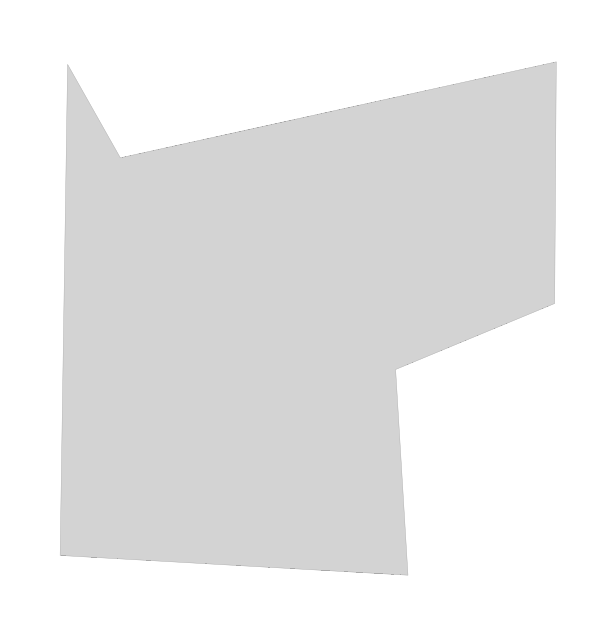

In [8]:
# Plot the GeoDataFrame
geoplot.polyplot(
    gdf,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
)

*NetCDF file*

In [10]:
# Open the NetCDF file
dataset = xr.open_dataset("geospatial_test_datacube.nc")
print(dataset)

<xarray.Dataset>
Dimensions:   (time: 23, y: 227, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 ...
    S2_GREEN  (time, y, x) float32 ...
    S2_BLUE   (time, y, x) float32 ...
    S2_NIR    (time, y, x) float32 ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


*Calculation of the Normalized Difference Vegetation Index (NDVI)*

In [12]:
# Extraction of the necessary bands
red_band = dataset['S2_RED']
nir_band = dataset['S2_NIR']

# Calcul du NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)
dataset['ndvi'] = ndvi

In [13]:
# Calculating the mean ndvi along the 'y' and 'x' axes for each date
ndvi_mean = ndvi.mean(dim=['y', 'x'])
ndvi_mean

<xarray.DataArray (time: 23)>
array([0.56018096, 0.5794525 , 0.57688075, 0.57922804, 0.65087914,
       0.8123323 , 0.8187215 , 0.85271674, 0.86178267, 0.82305306,
       0.7636362 , 0.79315066, 0.85102844, 0.8446867 , 0.82339054,
       0.8251109 , 0.7314527 , 0.6308673 , 0.6736543 , 0.6529785 ,
       0.6599584 , 0.67853653, 0.640067  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25

**Interpretation**:<br>

The mean NDVI values range from approximately 0.56 to 0.86.
Higher mean NDVI values indicate denser vegetation or healthier vegetation cover.
Fluctuations in mean NDVI values over time may reflect changes in vegetation health, growth, or land use practices.
Analyzing these fluctuations can provide insights into seasonal variations, vegetation response to environmental conditions,
or human activities impacting vegetation cover.

#### Visual RGB image

*RGB_image*

In [17]:
date_index = 0  # We can choose a different date index (I chose date 0)
red_band = dataset['S2_RED'][date_index]
green_band = dataset['S2_GREEN'][date_index]
blue_band = dataset['S2_BLUE'][date_index]

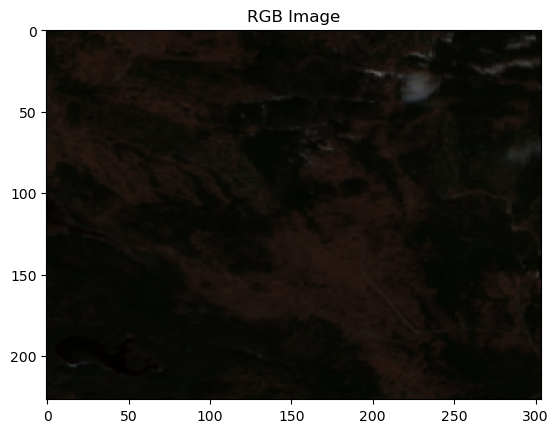

In [18]:
# Concatenate the bands into an RGB image
rgb_image = xr.concat([red_band, green_band, blue_band], dim='color').transpose('y', 'x', 'color')

# Plot the RGB image
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.show()

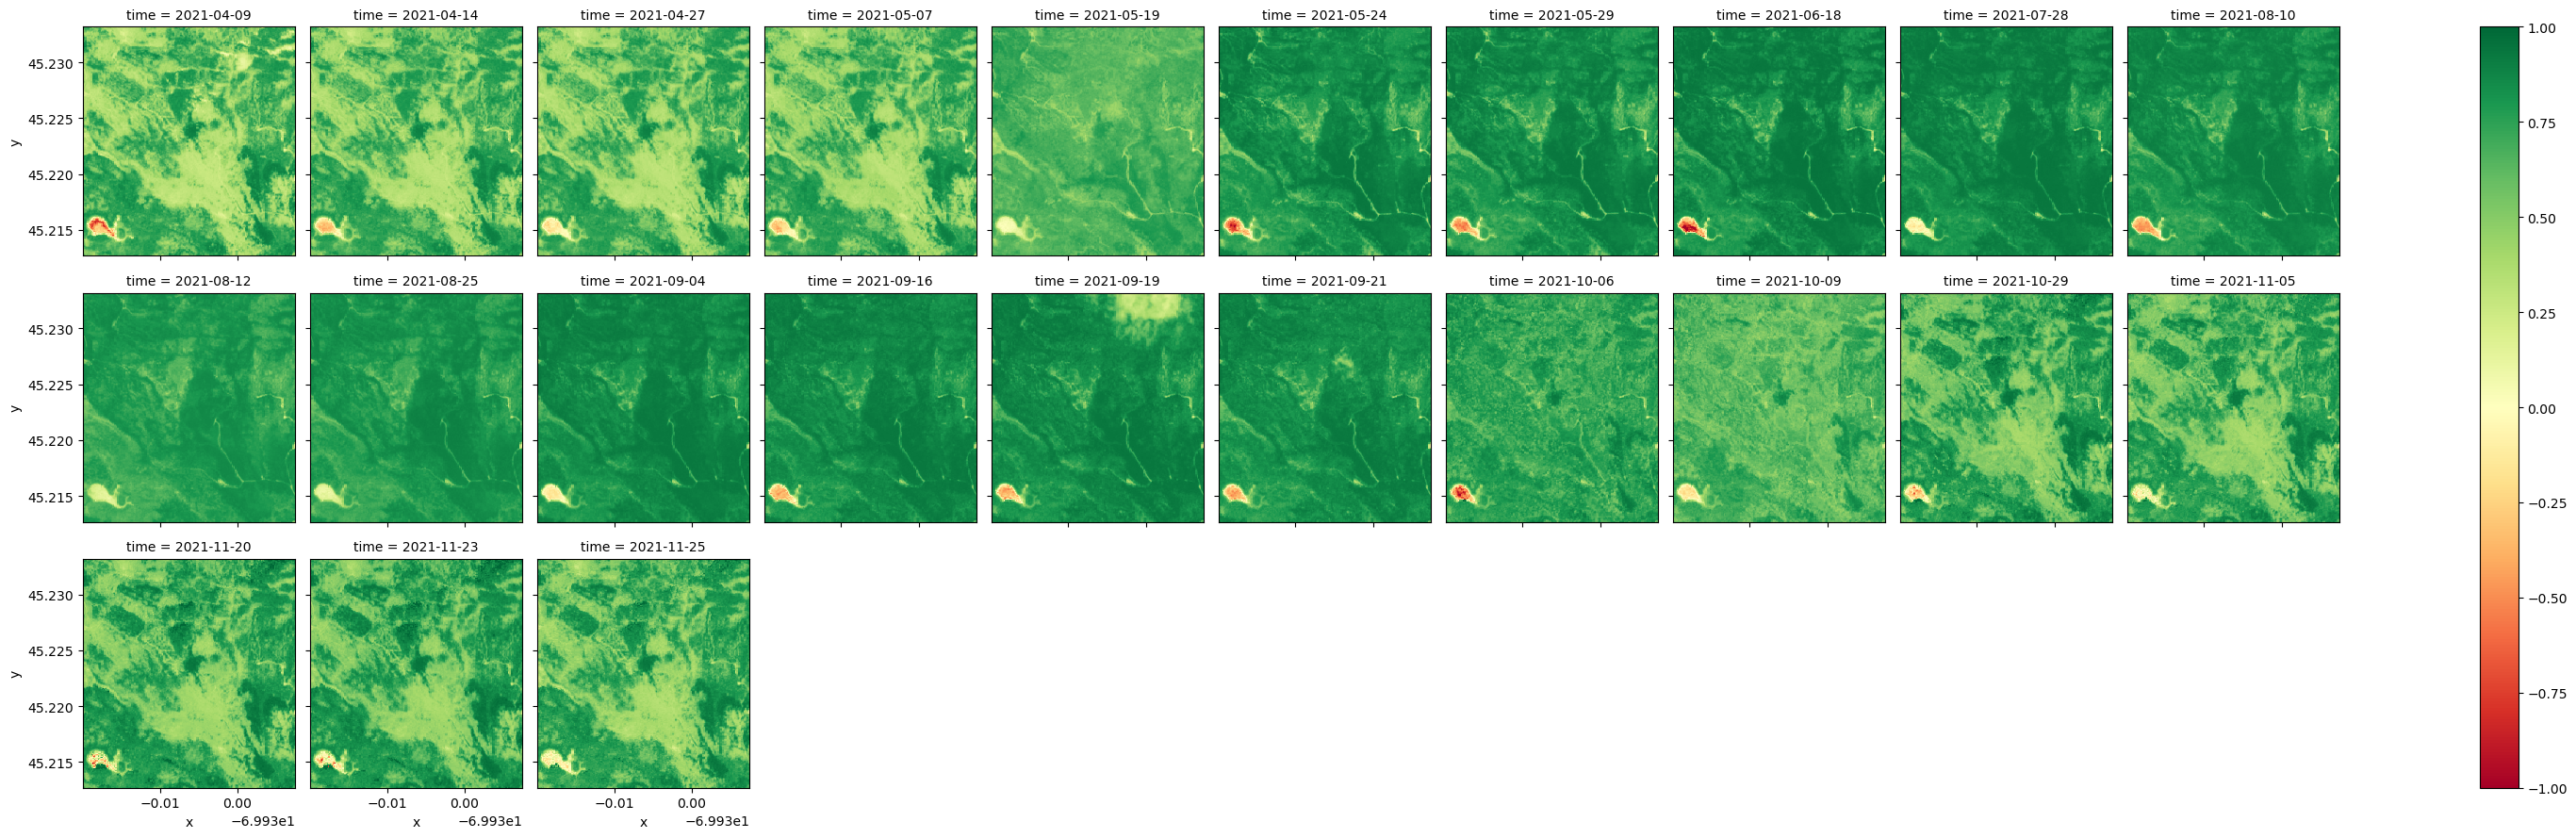

In [19]:
# display the time series of NDVI images
ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=10, cmap="RdYlGn")
plt.show()


CPU times: total: 406 ms
Wall time: 573 ms


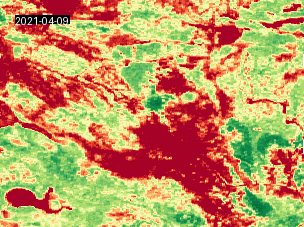

In [20]:
%%time
gif(ndvi.compute(), fps=5, cmap="RdYlGn")

#### Distribution (histogram) of NDVI pixels

In [22]:
ndvi_flat = ndvi.values.ravel()
ndvi_flat

array([0.62311345, 0.62311345, 0.6612276 , ..., 0.7311089 , 0.8158915 ,
       0.7271214 ], dtype=float32)

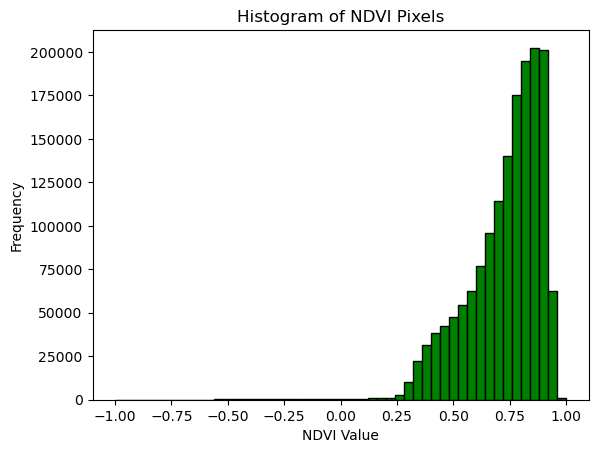

In [23]:
# Plot the histogram
plt.hist(ndvi_flat, bins=50, color='green', edgecolor='black')
plt.title('Histogram of NDVI Pixels')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.show()

In [24]:
ndvi_filtered = ndvi_flat[(ndvi_flat >= 0.6) & (ndvi_flat <= 1.0)]
len(ndvi_filtered)/len(ndvi_flat)

0.7950439268541013

**Interpretation** <br>
This analysis shows that approximately 79.5% of the pixels in our data have NDVI values ranging from 0.6 to 1.0. This suggests that vegetation is quite prevalent in the studied area, as higher NDVI values are typically associated with denser and healthier vegetation. This can be useful for assessing the overall health of vegetation in the region, as well as for tracking changes in vegetation cover over time.

#### Time series of NDVI averaged over the AOI

*the choice of AOI*

In [28]:
# Define the boundaries of the area of interest
x_min = -69.95 # Minimum value of x
x_max = -69.92 # Maximum value of x
y_min = 45.21 # Minimum value of y
y_max = 45.23 # Maximum value of y

# Select indices corresponding to the boundaries in your x and y coordinates
x_indices = np.where((dataset.x >= x_min) & (dataset.x <= x_max))[0]
y_indices = np.where((dataset.y >= y_min) & (dataset.y <= y_max))[0]

# Create a new area of interest based on the selected indices
zone_of_interest = dataset.isel(x=x_indices, y=y_indices)

In [29]:
zone_of_interest

<xarray.Dataset>
Dimensions:   (time: 23, y: 192, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 ...
    S2_GREEN  (time, y, x) float32 ...
    S2_BLUE   (time, y, x) float32 ...
    S2_NIR    (time, y, x) float32 ...
    ndvi      (time, y, x) float32 0.496 0.3896 0.3818 ... 0.7311 0.8159 0.7271
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]

In [30]:
zone_of_interest['time']

<xarray.DataArray 'time' (time: 23)>
array(['2021-04-09T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-27T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-29T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-07-28T00:00:00.000000000', '2021-08-10T00:00:00.000000000',
       '2021-08-12T00:00:00.000000000', '2021-08-25T00:00:00.000000000',
       '2021-09-04T00:00:00.000000000', '2021-09-16T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2021-09-21T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-11-05T00:00:00.000000000',
       '2021-11-20T00:00:00.000000000', '2021-11-23T00:00:00.000000000',
       '2021-11-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25

In [31]:
# Calculate the mean NDVI over the area of interest for each date
mean_ndvi_over_zone = zone_of_interest.ndvi.mean(dim=('y', 'x'))

# Create a time series for the dates
dates = mean_ndvi_over_zone['time'].values
ndvi_values = mean_ndvi_over_zone.values
ndvi_values

array([0.5627679 , 0.5795277 , 0.5777309 , 0.58012336, 0.652357  ,
       0.80719274, 0.8130195 , 0.84636307, 0.8569748 , 0.81648505,
       0.7586019 , 0.78974277, 0.846828  , 0.8402006 , 0.84103125,
       0.8203961 , 0.7298061 , 0.63297987, 0.6694513 , 0.6503335 ,
       0.6574491 , 0.6745137 , 0.6365422 ], dtype=float32)

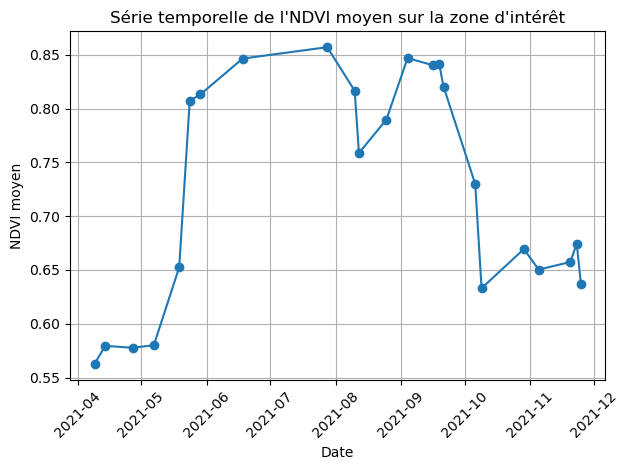

In [32]:
# Plot the time series of the average NDVI index over the area of interest
plt.plot(dates, ndvi_values, marker='o', linestyle='-')
plt.title('Série temporelle de l\'NDVI moyen sur la zone d\'intérêt')
plt.xlabel('Date')
plt.ylabel('NDVI moyen')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation** <br>

* The results depict the evolution of the Normalized Difference Vegetation Index (NDVI) averaged over the area of interest for different dates:

* Seasonal vegetation dynamics: NDVI values show a gradual increase from April to July, with minor fluctuations. This suggests an increment in vegetation density during this period, consistent with the growing seasons in many regions.

* Vegetation peak: The peak vegetation density appears to occur around late July to early August, where the NDVI reaches its maximum values, exceeding even 0.85. This may correspond to the peak of the growing season when vegetation is at its zenith in terms of health and vigor.

* Decrease in NDVI: After the vegetation peak, there's a slight decrease in NDVI from September to late November. This could correspond to the end of the growing season and the onset of the winter dormancy period, where vegetation starts to lose density and vigor.

* Fluctuations: Between these key periods, fluctuations in NDVI values are observed, which could be due to various factors such as climatic variations, precipitation, temperatures, or even human activities like irrigation or land management.



#### Visualization of NDVI clipped to the provided sub-AOI

In [35]:
print(gdf['geometry'].unique())

<GeometryArray>
[<POLYGON ((-69.949 45.232, -69.949 45.217, -69.934 45.217, -69.934 45.223, -...>]
Length: 1, dtype: geometry


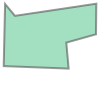

In [36]:
# Extraire les coordonnées du polygone du sous-AOI
polygon = gdf.geometry.values[0]
polygon

In [37]:
# Extract the polygon from the "geometry" column
polygon = gdf['geometry'].iloc[0]

# Extract x and y coordinates
x_coords = polygon.exterior.xy[0]
y_coords = polygon.exterior.xy[1]

# Print the coordinates
print("X coordinates:", list(x_coords))
print("Y coordinates:", list(y_coords))

X coordinates: [-69.94866840794437, -69.94899780345483, -69.93355281398054, -69.93410180649703, -69.92703810278044, -69.92696490377774, -69.94632603987228, -69.94866840794437]
Y coordinates: [45.232267539891154, 45.217496757461305, 45.216903783807965, 45.223091030586374, 45.22507596293357, 45.23234486373087, 45.229458035687884, 45.232267539891154]


In [38]:
gdf.geometry.bounds

minx       miny       maxx       maxy
0 -69.948998  45.216904 -69.926965  45.232345

In [39]:
# Define the x and y range from the polygon coordinates
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

# Extract raster values inside the polygon
ndvi_sub = ndvi.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

# Display ndvi_sub values
print(ndvi_sub)

<xarray.DataArray (time: 23, y: 170, x: 245)>
array([[[0.3992121 , 0.3992121 , 0.46265933, ..., 0.7109557 ,
         0.7122359 , 0.726904  ],
        [0.43023616, 0.43023616, 0.42668432, ..., 0.5730994 ,
         0.56448346, 0.6921824 ],
        [0.53608966, 0.49557835, 0.40053406, ..., 0.6546392 ,
         0.5394737 , 0.6804836 ],
        ...,
        [0.592233  , 0.592233  , 0.46238452, ..., 0.74841774,
         0.5640051 , 0.4788174 ],
        [0.61852866, 0.61852866, 0.4740576 , ..., 0.76003057,
         0.6488237 , 0.49064752],
        [0.6131456 , 0.6131456 , 0.51461244, ..., 0.75310344,
         0.76541257, 0.63848925]],

       [[0.45357922, 0.45357922, 0.51716316, ..., 0.76219505,
         0.69814503, 0.70255476],
        [0.41369697, 0.41369697, 0.45521247, ..., 0.715923  ,
         0.6902887 , 0.72884285],
        [0.5865922 , 0.41272333, 0.40689653, ..., 0.69890666,
         0.6454849 , 0.71783495],
...
        [0.634861  , 0.634861  , 0.6309677 , ..., 0.8154507 ,
         

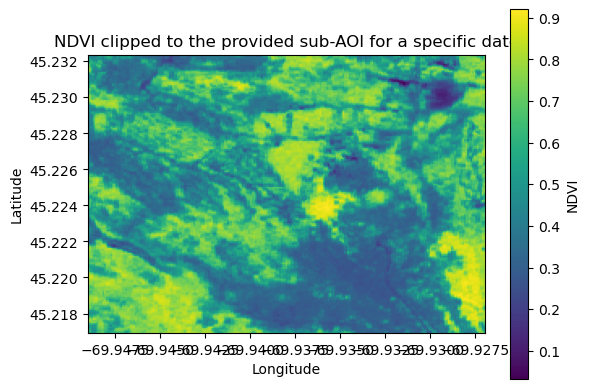

In [40]:
# Select a specific date to display
ndvi_date = ndvi_sub.isel(time=0) # Select the first date (index 0) for example

# Visualization of the clipped NDVI for a specific single date
plt.imshow(ndvi_date, cmap='viridis', extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label='NDVI')
plt.title('NDVI clipped to the provided sub-AOI for a specific date')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

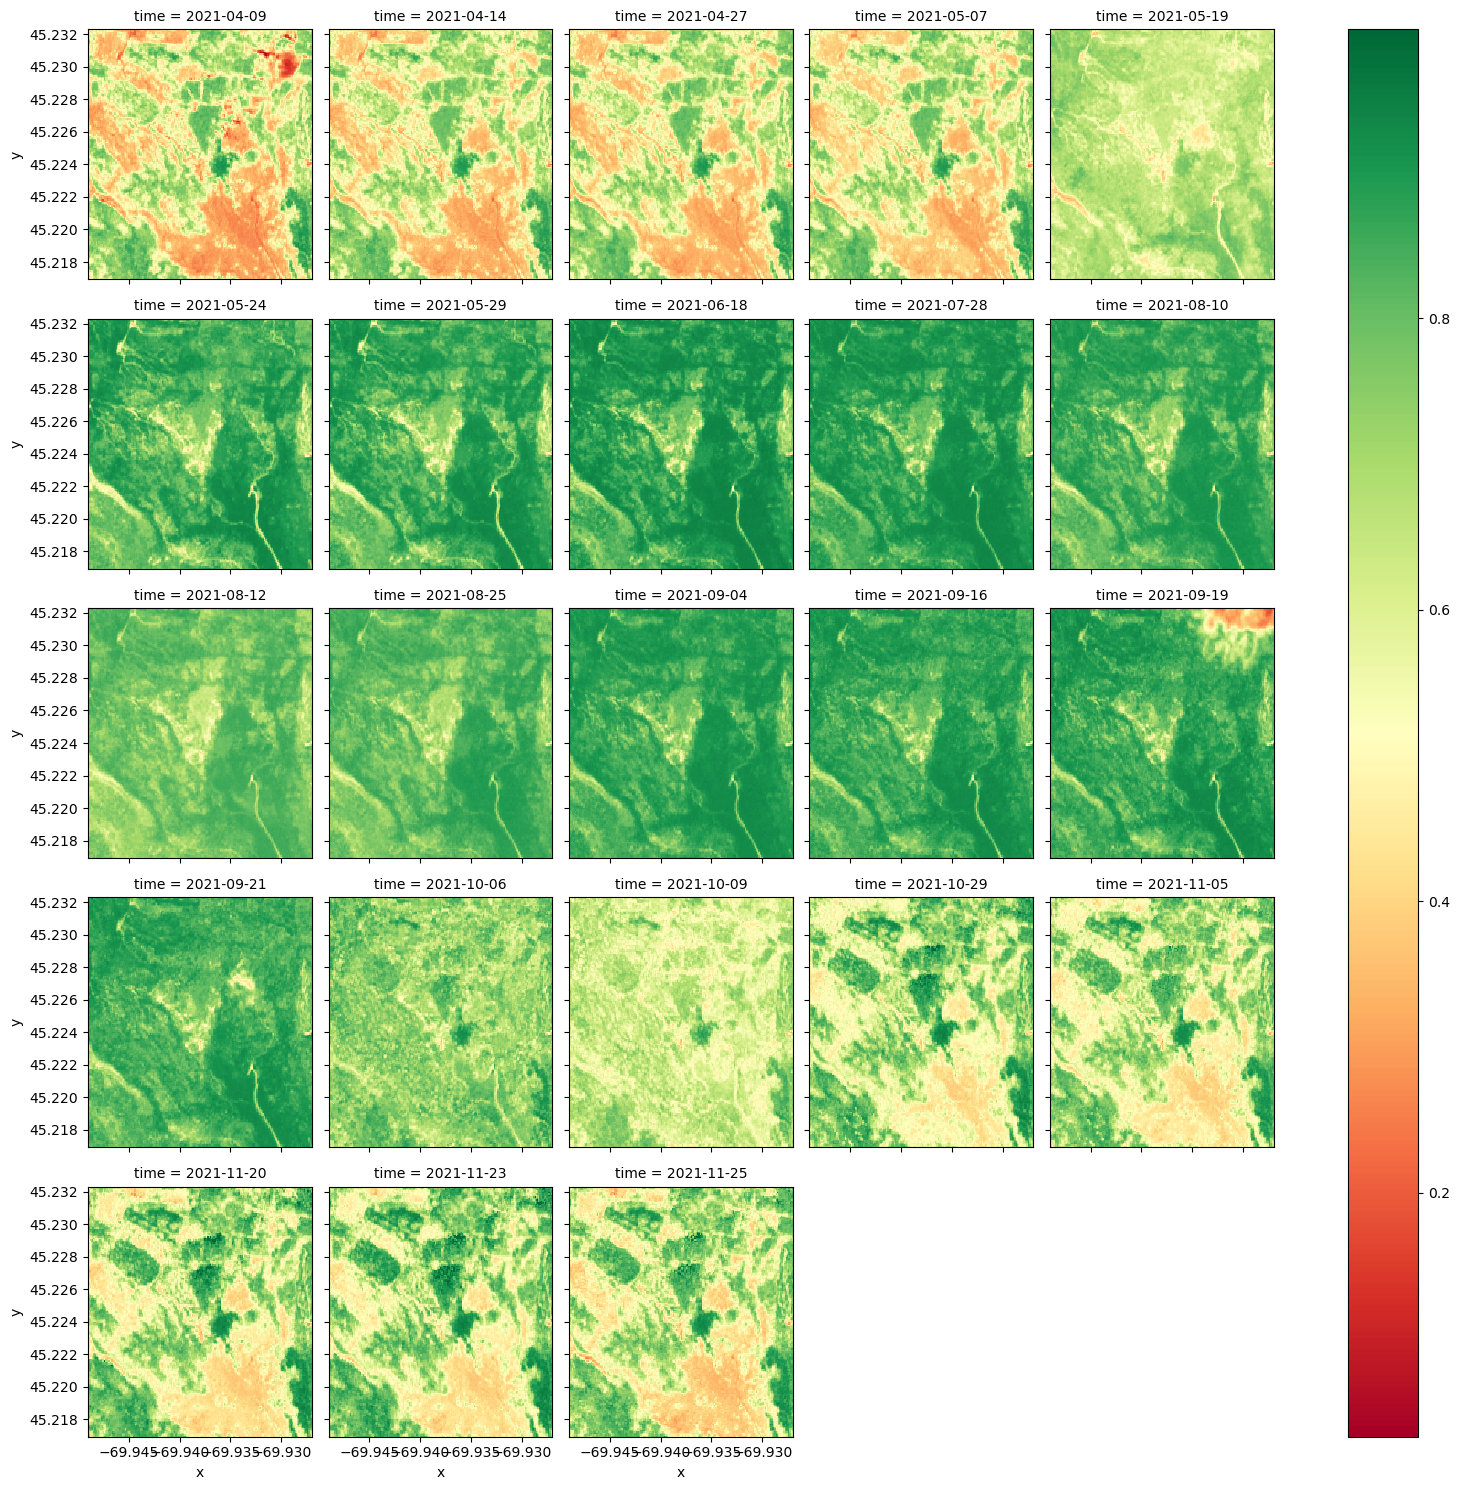

In [41]:
# Select the region of interest
ndvi_roi = ndvi.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

# Display the time series of NDVI images for the region of interest
ndvi_roi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="RdYlGn")
plt.show()


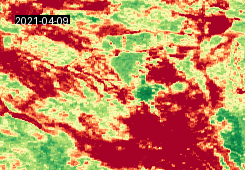

In [42]:
# Create the GIF for the time series of NDVI images for the region of interest
gif(ndvi_roi.compute(), fps=5, cmap="RdYlGn")